In [4]:
# ===== 셀 1: 환경 설정 =====
import json
import shutil
from pathlib import Path
import numpy as np
from PIL import Image, ImageFilter, ImageEnhance
import random
import copy
from tqdm import tqdm
import traceback

# 경로 설정
source_root = Path(r'C:\EngineBladeAI\EngineInspectionAI_MS\data\multilabeled_data')
target_root = Path(r'C:\EngineBladeAI\EngineInspectionAI_MS\data\multilabeled_data_augmented')

# 대상 폴더 생성
target_root.mkdir(exist_ok=True)
for split in ['train', 'valid', 'test']:
    (target_root / split).mkdir(exist_ok=True)

print(f"Source: {source_root}")
print(f"Target: {target_root}")
print("✅ 폴더 구조 생성 완료")

Source: C:\EngineBladeAI\EngineInspectionAI_MS\data\multilabeled_data
Target: C:\EngineBladeAI\EngineInspectionAI_MS\data\multilabeled_data_augmented
✅ 폴더 구조 생성 완료


In [5]:
# ===== 셀 2: MultiLabelAugmentation 클래스 정의 =====
class MultiLabelAugmentation:
    """멀티라벨 데이터 증강 클래스"""
    
    def __init__(self, 
                 rotation_90_prob=0.3,
                 rotation_180_prob=0.2,
                 rotation_270_prob=0.3,
                 blur_prob=0.2,
                 brightness_prob=0.3,
                 contrast_prob=0.3):
        
        self.rotation_90_prob = rotation_90_prob
        self.rotation_180_prob = rotation_180_prob
        self.rotation_270_prob = rotation_270_prob
        self.blur_prob = blur_prob
        self.brightness_prob = brightness_prob
        self.contrast_prob = contrast_prob
    
    def rotate_90_coords(self, image, annotations, direction='cw'):
        """90도 회전 + 좌표 변환"""
        width, height = image.size
        
        if direction == 'cw':  # 시계방향
            rotated_image = image.rotate(-90, expand=True)
            new_annotations = []
            
            for ann in annotations:
                new_ann = copy.deepcopy(ann)
                
                # segmentation 좌표 변환
                if 'segmentation' in ann and ann['segmentation']:
                    new_segs = []
                    for seg in ann['segmentation']:
                        if isinstance(seg, list) and len(seg) >= 6:
                            coords = np.array(seg).reshape(-1, 2)
                            # 시계방향 90도: (x,y) -> (y, width-x)
                            new_coords = np.column_stack([coords[:, 1], width - coords[:, 0]])
                            new_segs.append(new_coords.flatten().tolist())
                    new_ann['segmentation'] = new_segs
                
                # bbox 변환 [x, y, w, h]
                if 'bbox' in ann:
                    x, y, w, h = ann['bbox']
                    new_ann['bbox'] = [y, width - x - w, h, w]
                
                new_annotations.append(new_ann)
                
        else:  # 반시계방향
            rotated_image = image.rotate(90, expand=True)
            new_annotations = []
            
            for ann in annotations:
                new_ann = copy.deepcopy(ann)
                
                if 'segmentation' in ann and ann['segmentation']:
                    new_segs = []
                    for seg in ann['segmentation']:
                        if isinstance(seg, list) and len(seg) >= 6:
                            coords = np.array(seg).reshape(-1, 2)
                            # 반시계방향 90도: (x,y) -> (height-y, x)
                            new_coords = np.column_stack([height - coords[:, 1], coords[:, 0]])
                            new_segs.append(new_coords.flatten().tolist())
                    new_ann['segmentation'] = new_segs
                
                if 'bbox' in ann:
                    x, y, w, h = ann['bbox']
                    new_ann['bbox'] = [height - y - h, x, h, w]
                
                new_annotations.append(new_ann)
        
        return rotated_image, new_annotations
    
    def rotate_180_coords(self, image, annotations):
        """180도 회전 + 좌표 변환"""
        width, height = image.size
        rotated_image = image.rotate(180)
        new_annotations = []
        
        for ann in annotations:
            new_ann = copy.deepcopy(ann)
            
            if 'segmentation' in ann and ann['segmentation']:
                new_segs = []
                for seg in ann['segmentation']:
                    if isinstance(seg, list) and len(seg) >= 6:
                        coords = np.array(seg).reshape(-1, 2)
                        # 180도: (x,y) -> (width-x, height-y)
                        new_coords = np.column_stack([width - coords[:, 0], height - coords[:, 1]])
                        new_segs.append(new_coords.flatten().tolist())
                new_ann['segmentation'] = new_segs
            
            if 'bbox' in ann:
                x, y, w, h = ann['bbox']
                new_ann['bbox'] = [width - x - w, height - y - h, w, h]
            
            new_annotations.append(new_ann)
        
        return rotated_image, new_annotations
    
    def apply_blur(self, image):
        """블러 효과"""
        radius = random.uniform(0.5, 2.0)
        return image.filter(ImageFilter.GaussianBlur(radius=radius))
    
    def adjust_brightness(self, image):
        """밝기 조정"""
        enhancer = ImageEnhance.Brightness(image)
        factor = random.uniform(0.7, 1.3)
        return enhancer.enhance(factor)
    
    def adjust_contrast(self, image):
        """대비 조정"""
        enhancer = ImageEnhance.Contrast(image)
        factor = random.uniform(0.7, 1.3)
        return enhancer.enhance(factor)
    
    def augment(self, image, annotations):
        """전체 증강 파이프라인"""
        aug_results = []
        
        # 원본 추가
        aug_results.append(('original', image, annotations))
        
        # 회전 증강
        if random.random() < self.rotation_90_prob:
            aug_img, aug_anns = self.rotate_90_coords(image, annotations, 'cw')
            aug_results.append(('rotate_90_cw', aug_img, aug_anns))
        
        if random.random() < self.rotation_180_prob:
            aug_img, aug_anns = self.rotate_180_coords(image, annotations)
            aug_results.append(('rotate_180', aug_img, aug_anns))
        
        if random.random() < self.rotation_270_prob:
            aug_img, aug_anns = self.rotate_90_coords(image, annotations, 'ccw')
            aug_results.append(('rotate_270_ccw', aug_img, aug_anns))
        
        # 픽셀 레벨 증강 (좌표 변경 없음)
        final_results = []
        for aug_type, aug_img, aug_anns in aug_results:
            final_img = aug_img.copy()
            
            if random.random() < self.blur_prob:
                final_img = self.apply_blur(final_img)
                aug_type += '_blur'
            
            if random.random() < self.brightness_prob:
                final_img = self.adjust_brightness(final_img)
                aug_type += '_bright'
            
            if random.random() < self.contrast_prob:
                final_img = self.adjust_contrast(final_img)
                aug_type += '_contrast'
            
            final_results.append((aug_type, final_img, aug_anns))
        
        return final_results

print("✅ MultiLabelAugmentation 클래스 정의 완료")

✅ MultiLabelAugmentation 클래스 정의 완료


In [6]:
# ===== 셀 3: 데이터 증강 함수 =====
def augment_dataset(split='train', augment_factor=3):
    """데이터셋 증강 및 저장"""
    
    print(f"\n{'='*60}")
    print(f"{split} 데이터 증강 시작")
    print(f"{'='*60}")
    
    # JSON 로드
    json_path = source_root / split / 'damage_multilabel.json'
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    print(f"원본 이미지: {len(data['images'])}개")
    print(f"원본 Annotations: {len(data['annotations'])}개")
    
    # 증강기 생성
    if split == 'train':
        # 학습 데이터는 적극적으로 증강
        augmentor = MultiLabelAugmentation(
            rotation_90_prob=0.4,
            rotation_180_prob=0.3,
            rotation_270_prob=0.4,
            blur_prob=0.2,
            brightness_prob=0.3,
            contrast_prob=0.3
        )
    else:
        # valid/test는 증강 없음 (원본만 복사)
        augmentor = None
    
    # 새로운 데이터 준비
    new_data = {
        'info': data.get('info', {}),
        'licenses': data.get('licenses', []),
        'categories': data['categories'],
        'images': [],
        'annotations': []
    }
    
    new_img_id = 0
    new_ann_id = 0
    
    # 각 이미지별로 처리
    for img_info in tqdm(data['images'], desc=f"Processing {split}"):
        img_path = source_root / split / img_info['file_name']
        
        if not img_path.exists():
            print(f"⚠️ 이미지 없음: {img_path}")
            continue
        
        # 해당 이미지의 annotations
        img_annotations = [
            ann for ann in data['annotations']
            if ann['image_id'] == img_info['id']
        ]
        
        try:
            # 이미지 로드
            image = Image.open(img_path).convert('RGB')
            
            if augmentor and split == 'train':
                # 증강 적용
                aug_results = augmentor.augment(image, img_annotations)
            else:
                # 증강 없이 원본만
                aug_results = [('original', image, img_annotations)]
            
            # 각 증강 결과 저장
            for aug_idx, (aug_type, aug_img, aug_anns) in enumerate(aug_results):
                # 새 파일명
                base_name = Path(img_info['file_name']).stem
                ext = Path(img_info['file_name']).suffix
                
                if aug_type == 'original':
                    new_filename = f"{base_name}{ext}"
                else:
                    new_filename = f"{base_name}_aug{aug_idx}_{aug_type}{ext}"
                
                # 이미지 저장
                save_path = target_root / split / new_filename
                aug_img.save(save_path, quality=95)
                
                # 이미지 정보 추가
                new_img_info = {
                    'id': new_img_id,
                    'file_name': new_filename,
                    'width': aug_img.width,
                    'height': aug_img.height,
                    'original_id': img_info['id']
                }
                new_data['images'].append(new_img_info)
                
                # Annotation 추가
                for ann in aug_anns:
                    new_ann = copy.deepcopy(ann)
                    new_ann['id'] = new_ann_id
                    new_ann['image_id'] = new_img_id
                    new_data['annotations'].append(new_ann)
                    new_ann_id += 1
                
                new_img_id += 1
                
        except Exception as e:
            print(f"❌ 오류 발생 ({img_info['file_name']}): {e}")
            traceback.print_exc()
            continue
    
    # JSON 저장
    json_save_path = target_root / split / 'damage_multilabel.json'
    with open(json_save_path, 'w') as f:
        json.dump(new_data, f, indent=2)
    
    print(f"\n✅ {split} 증강 완료:")
    print(f"  증강 후 이미지: {len(new_data['images'])}개")
    print(f"  증강 후 Annotations: {len(new_data['annotations'])}개")
    print(f"  증강 비율: {len(new_data['images']) / len(data['images']):.2f}x")
    
    return new_data

In [7]:
# ===== 셀 4: 전체 데이터셋 증강 실행 =====
# Train 데이터 증강 (적극적)
train_augmented = augment_dataset('train', augment_factor=3)

# Valid 데이터 복사 (증강 없음)
valid_augmented = augment_dataset('valid', augment_factor=1)

# Test 데이터 복사 (증강 없음)
test_augmented = augment_dataset('test', augment_factor=1)

print("\n" + "="*60)
print("전체 증강 완료!")
print("="*60)


train 데이터 증강 시작
원본 이미지: 2246개
원본 Annotations: 3179개


Processing train: 100%|██████████| 2246/2246 [00:33<00:00, 66.41it/s]



✅ train 증강 완료:
  증강 후 이미지: 4704개
  증강 후 Annotations: 6608개
  증강 비율: 2.09x

valid 데이터 증강 시작
원본 이미지: 906개
원본 Annotations: 1060개


Processing valid: 100%|██████████| 906/906 [00:05<00:00, 178.86it/s]



✅ valid 증강 완료:
  증강 후 이미지: 906개
  증강 후 Annotations: 1060개
  증강 비율: 1.00x

test 데이터 증강 시작
원본 이미지: 919개
원본 Annotations: 1060개


Processing test: 100%|██████████| 919/919 [00:05<00:00, 180.22it/s]



✅ test 증강 완료:
  증강 후 이미지: 919개
  증강 후 Annotations: 1060개
  증강 비율: 1.00x

전체 증강 완료!


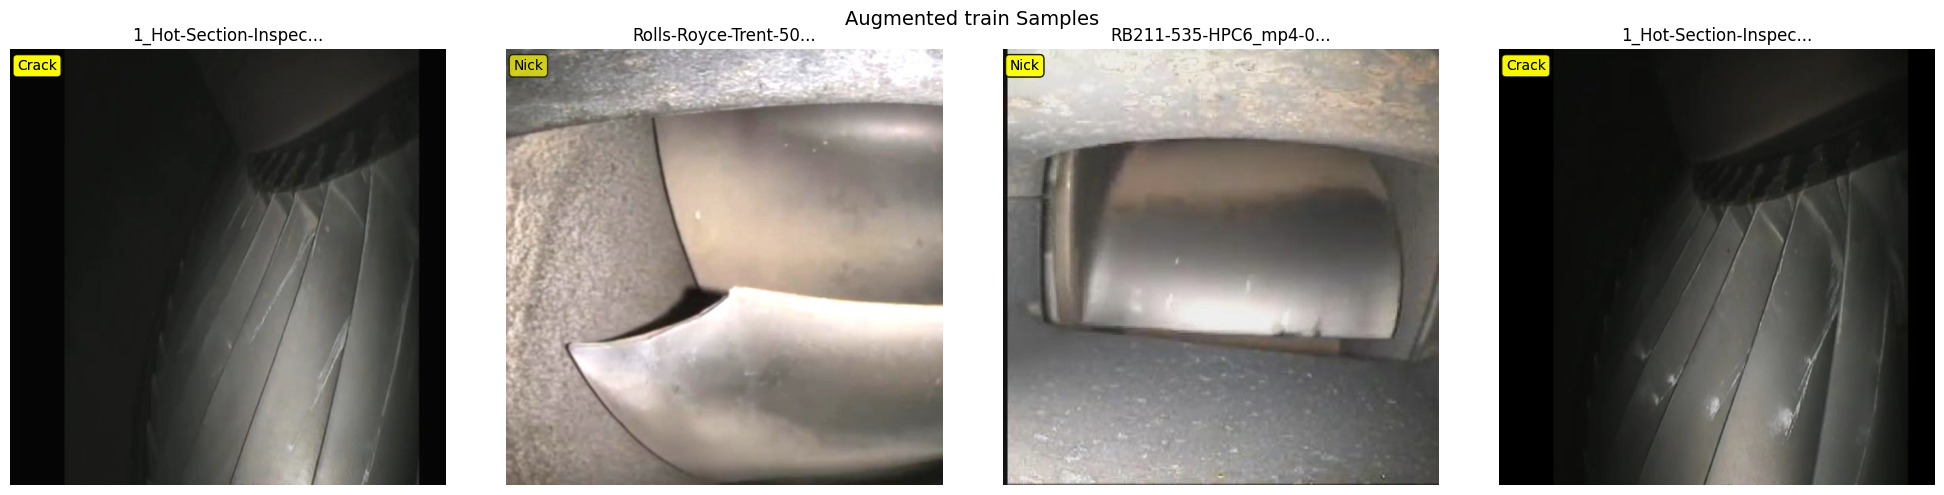

저장된 경로: augmented_samples_train.png


In [10]:
# ===== 셀 5 대안: IPython display 사용 =====
from IPython.display import display, Image as IPImage
import matplotlib.pyplot as plt

def visualize_augmented_samples_ipython(split='train', num_samples=3):
    """증강된 샘플 시각화 (IPython)"""
    
    # 증강된 데이터 로드
    json_path = target_root / split / 'damage_multilabel.json'
    with open(json_path, 'r') as f:
        aug_data = json.load(f)
    
    # 랜덤 샘플 선택
    sample_imgs = random.sample(aug_data['images'], min(num_samples, len(aug_data['images'])))
    
    # matplotlib 설정
    plt.ioff()  # interactive mode off
    
    fig, axes = plt.subplots(1, num_samples, figsize=(5*num_samples, 5))
    if num_samples == 1:
        axes = [axes]
    
    for idx, img_info in enumerate(sample_imgs):
        img_path = target_root / split / img_info['file_name']
        
        if img_path.exists():
            image = Image.open(img_path)
            axes[idx].imshow(image)
            axes[idx].set_title(f"{img_info['file_name'][:20]}...")
            
            # Annotations 표시
            img_anns = [ann for ann in aug_data['annotations'] if ann['image_id'] == img_info['id']]
            
            for ann in img_anns:
                if 'multilabel' in ann:
                    labels = ann['multilabel']
                    damage_types = ['Crack', 'Nick', 'Tear']
                    active_labels = [damage_types[i] for i, v in enumerate(labels) if v]
                    if active_labels:
                        axes[idx].text(10, 30, ', '.join(active_labels), 
                                     bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
            
            axes[idx].axis('off')
    
    plt.suptitle(f'Augmented {split} Samples', fontsize=14)
    plt.tight_layout()
    
    # 파일로 저장 후 표시
    save_path = f'augmented_samples_{split}.png'
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.close()
    
    # IPython에서 표시
    display(IPImage(filename=save_path))
    
    return save_path

# 사용
saved_path = visualize_augmented_samples_ipython('train', num_samples=4)
print(f"저장된 경로: {saved_path}")

In [11]:
# ===== 셀 6: 최종 통계 =====
print("="*60)
print("최종 증강 통계")
print("="*60)

for split in ['train', 'valid', 'test']:
    # 원본
    orig_json = source_root / split / 'damage_multilabel.json'
    with open(orig_json, 'r') as f:
        orig_data = json.load(f)
    
    # 증강
    aug_json = target_root / split / 'damage_multilabel.json'
    with open(aug_json, 'r') as f:
        aug_data = json.load(f)
    
    print(f"\n{split}:")
    print(f"  원본: {len(orig_data['images'])} images, {len(orig_data['annotations'])} annotations")
    print(f"  증강: {len(aug_data['images'])} images, {len(aug_data['annotations'])} annotations")
    print(f"  증강 비율: {len(aug_data['images']) / len(orig_data['images']):.2f}x")
    
    # 멀티라벨 통계
    multi_count = 0
    for ann in aug_data['annotations']:
        if 'multilabel' in ann and sum(ann['multilabel']) > 1:
            multi_count += 1
    
    if multi_count > 0:
        print(f"  멀티라벨 (복합 손상): {multi_count}개 ({multi_count/len(aug_data['annotations'])*100:.1f}%)")

print("\n✅ 모든 증강 데이터가 다음 경로에 저장됨:")
print(f"   {target_root}")

최종 증강 통계

train:
  원본: 2246 images, 3179 annotations
  증강: 4704 images, 6608 annotations
  증강 비율: 2.09x
  멀티라벨 (복합 손상): 612개 (9.3%)

valid:
  원본: 906 images, 1060 annotations
  증강: 906 images, 1060 annotations
  증강 비율: 1.00x
  멀티라벨 (복합 손상): 105개 (9.9%)

test:
  원본: 919 images, 1060 annotations
  증강: 919 images, 1060 annotations
  증강 비율: 1.00x
  멀티라벨 (복합 손상): 103개 (9.7%)

✅ 모든 증강 데이터가 다음 경로에 저장됨:
   C:\EngineBladeAI\EngineInspectionAI_MS\data\multilabeled_data_augmented
